In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

#sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error

#keras
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, BatchNormalization, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.experimental.preprocessing import Normalization


#others
import os
import json
from pathlib import Path
import joblib
import folium
import geojson
import geopandas as gpd
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBRegressor, plot_importance, plot_tree

In [2]:
data = yf.download('NVDA AMD INTC', start='2014-01-01', end='2021-08-04', group_by='ticker')

[*********************100%***********************]  3 of 3 completed


In [3]:
data

NVDA                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2014-01-02    3.980000    3.995000    3.930000    3.965000    3.746341   
2014-01-03    3.972500    3.980000    3.905000    3.917500    3.701460   
2014-01-06    3.957500    4.000000    3.920000    3.970000    3.751065   
2014-01-07    4.010000    4.050000    3.982500    4.035000    3.812481   
2014-01-08    4.050000    4.110000    4.035000    4.090000    3.864448   
...                ...         ...         ...         ...         ...   
2021-07-28  193.190002  196.460007  189.949997  195.029999  194.995605   
2021-07-29  195.190002  198.529999  193.279999  196.619995  196.585327   
2021-07-30  194.179993  196.300003  192.630005  194.990005  194.955627   
2021-08-02  197.000000  199.610001  193.610001  197.500000  197.465179   
2021-08-03  197.399994  202.220001  192.199997  198.149994  198.115051   

                             AMD                                      \
              Volume        Open        High         Low       Close   
Date                                                                   
2014-01-02  26009200    3.850000    3.980000    3.840000    3.950000   
2014-01-03  25933200    3.980000    4.000000    3.880000    4.000000   
2014-01-06  40949200    4.010000    4.180000    3.990000    4.130000   
2014-01-07  33328800    4.190000    4.250000    4.110000    4.180000   
2014-01-08  30819200    4.230000    4.260000    4.140000    4.180000   
...              ...         ...         ...         ...         ...   
2021-07-28  20219100   93.440002   98.709999   89.650002   97.930000   
2021-07-29  19078100   96.580002  105.739998   96.580002  102.949997   
2021-07-30  18322900  101.599998  106.970001  101.379997  106.190002   
2021-08-02  21744400  105.930000  110.330002  103.830002  108.629997   
2021-08-03  30181100  108.150002  114.849998  107.660004  112.559998   

                                        INTC                                   \
             Adj Close     Volume       Open       High        Low      Close   
Date                                                                            
2014-01-02    3.950000   20548400  25.780001  25.820000  25.469999  25.790001   
2014-01-03    4.000000   22887200  25.860001  25.900000  25.600000  25.780001   
2014-01-06    4.130000   42398300  25.770000  25.790001  25.450001  25.459999   
2014-01-07    4.180000   42932100  25.540001  25.730000  25.469999  25.590000   
2014-01-08    4.180000   30678700  25.639999  25.709999  25.299999  25.430000   
...                ...        ...        ...        ...        ...        ...   
2021-07-28   97.930000  140561000  53.029999  53.919998  52.939999  53.070000   
2021-07-29  102.949997  164091800  53.480000  54.099998  53.320000  53.700001   
2021-07-30  106.190002  125567000  53.650002  53.900002  53.250000  53.720001   
2021-08-02  108.629997  115581900  53.990002  54.470001  53.540001  53.680000   
2021-08-03  112.559998  157723100  53.889999  54.160000  53.259998  54.060001   

                                 
            Adj Close    Volume  
Date                             
2014-01-02  20.822496  31833300  
2014-01-03  20.814423  27796700  
2014-01-06  20.556065  28682300  
2014-01-07  20.661024  19665100  
2014-01-08  20.531837  29680500  
...               ...       ...  
2021-07-28  52.727360  28478800  
2021-07-29  53.353294  16886600  
2021-07-30  53.373165  16460000  
2021-08-02  53.333424  18098100  
2021-08-03  53.710968  16375900  

[1910 rows x 18 columns]

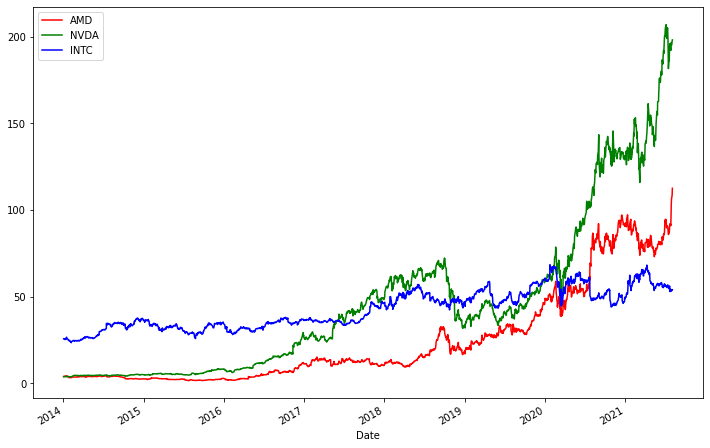

In [4]:
data['AMD']['Close'].plot(figsize=(12,8), color='red', label='AMD')
data['NVDA']['Close'].plot(color='green', label='NVDA')
data['INTC']['Close'].plot(color='blue', label='INTC')
plt.legend()

In [5]:
tickers_list = ['NVDA', 'AMD', 'INTC']
tickers_data = {}

for ticker in tickers_list:
    ticker_object = yf.Ticker(ticker)

    temp = pd.DataFrame.from_dict(ticker_object.info, orient='index')
    temp.reset_index(inplace=True)
    temp.columns = ['Attribute', 'Recent']

    tickers_data[ticker] = temp

tickers_data

{'NVDA':                Attribute                                             Recent
 0                    zip                                              95051
 1                 sector                                         Technology
 2      fullTimeEmployees                                              18975
 3    longBusinessSummary  NVIDIA Corporation operates as a visual comput...
 4                   city                                        Santa Clara
 ..                   ...                                                ...
 146        dividendYield                                             0.0008
 147              bidSize                                               1000
 148              dayHigh                                             208.58
 149   regularMarketPrice                                             207.42
 150             logo_url               https://logo.clearbit.com/nvidia.com
 
 [151 rows x 2 columns],
 'AMD':                Attribute         

In [6]:
#full list of infos

#'zip', 'sector', 'fullTimeEmployees', 'longBusinessSummary', 'city', 'phone', 'state', 'country', 'companyOfficers', 'website', 'maxAge',
# 'address1', 'industry', 'previousClose', 'regularMarketOpen', 'twoHundredDayAverage', 'trailingAnnualDividendYield', 'payoutRatio', 'volume24Hr',
#  'regularMarketDayHigh', 'navPrice', 'averageDailyVolume10Day', 'totalAssets', 'regularMarketPreviousClose', 'fiftyDayAverage', 'trailingAnnualDividendRate',
#  'open', 'toCurrency', 'averageVolume10days', 'expireDate', 'yield', 'algorithm', 'dividendRate', 'exDividendDate', 'beta', 'circulatingSupply', 'startDate',
#  'regularMarketDayLow', 'priceHint', 'currency', 'trailingPE', 'regularMarketVolume', 'lastMarket', 'maxSupply', 'openInterest', 'marketCap', 'volumeAllCurrencies',
#  'strikePrice', 'averageVolume', 'priceToSalesTrailing12Months', 'dayLow', 'ask', 'ytdReturn', 'askSize', 'volume', 'fiftyTwoWeekHigh', 'forwardPE', 'fromCurrency',
#  'fiveYearAvgDividendYield', 'fiftyTwoWeekLow', 'bid', 'tradeable', 'dividendYield', 'bidSize', 'dayHigh', 'exchange', 'shortName', 'longName', 'exchangeTimezoneName',
#  'exchangeTimezoneShortName', 'isEsgPopulated', 'gmtOffSetMilliseconds', 'quoteType', 'symbol', 'messageBoardId', 'market', 'annualHoldingsTurnover', 'enterpriseToRevenue',
#  'beta3Year', 'profitMargins', 'enterpriseToEbitda', '52WeekChange', 'morningStarRiskRating', 'forwardEps', 'revenueQuarterlyGrowth', 'sharesOutstanding', 'fundInceptionDate',
#  'annualReportExpenseRatio', 'bookValue', 'sharesShort', 'sharesPercentSharesOut', 'fundFamily', 'lastFiscalYearEnd', 'heldPercentInstitutions', 'netIncomeToCommon',
#  'trailingEps', 'lastDividendValue', 'SandP52WeekChange', 'priceToBook', 'heldPercentInsiders', 'nextFiscalYearEnd', 'mostRecentQuarter', 'shortRatio',
#  'sharesShortPreviousMonthDate', 'floatShares', 'enterpriseValue', 'threeYearAverageReturn', 'lastSplitDate', 'lastSplitFactor', 'legalType', 'lastDividendDate',
#  'morningStarOverallRating', 'earningsQuarterlyGrowth', 'dateShortInterest', 'pegRatio', 'lastCapGain', 'shortPercentOfFloat', 'sharesShortPriorMonth',
#  'impliedSharesOutstanding', 'category', 'fiveYearAverageReturn', 'regularMarketPrice', 'logo_url'

In [7]:
combined_data = pd.concat(tickers_data)
combined_data = combined_data.reset_index()
combined_data = combined_data.drop(columns=['level_1'], axis=1)
combined_data.columns = ['Ticker', 'Attributes', 'Recent']
combined_data

#looking at the attributes of the 3 tickers (NVDA, AMD, INTC)

,Ticker,Attributes,Recent
0,NVDA,zip,95051
1,NVDA,sector,Technology
2,NVDA,fullTimeEmployees,18975
3,NVDA,longBusinessSummary,NVIDIA Corporation operates as a visual comput...
4,NVDA,city,Santa Clara
...,...,...,...
448,INTC,dividendYield,0.0258
449,INTC,bidSize,800
450,INTC,dayHigh,54.105
451,INTC,regularMarketPrice,53.86


In [8]:
combined_data['Attributes']

0                      zip
1                   sector
2        fullTimeEmployees
3      longBusinessSummary
4                     city
              ...         
448          dividendYield
449                bidSize
450                dayHigh
451     regularMarketPrice
452               logo_url
Name: Attributes, Length: 453, dtype: object

In [9]:
employees = combined_data[combined_data['Attributes'] == 'fullTimeEmployees']
employees.sort_values(by='Recent', ascending=False)

#INTC is a much bigger company relative in employees count

,Ticker,Attributes,Recent
304,INTC,fullTimeEmployees,113700
2,NVDA,fullTimeEmployees,18975
153,AMD,fullTimeEmployees,12600


In [10]:
market_cap = combined_data[combined_data['Attributes'] == 'marketCap'].drop(columns='Attributes', axis=1)
company_hq = combined_data[combined_data['Attributes'] == 'city'].drop(columns='Attributes', axis=1)
five_year_div_yield = combined_data[combined_data['Attributes'] == 'fiveYearAvgDividendYield'].drop(columns='Attributes', axis=1)
company_hq.columns = ['Ticker', 'City']
market_cap.columns = ['Ticker', 'Market Cap']
five_year_div_yield.columns = ['Ticker', 'Dividend Yield (5 Years)']

In [11]:
market_cap

,Ticker,Market Cap
132,NVDA,516890624000
283,AMD,124268773376
434,INTC,218510016512


In [12]:
company_comparison = pd.merge(market_cap, company_hq, left_on='Ticker', right_on='Ticker')
company_comparison = pd.merge(company_comparison, five_year_div_yield, left_on='Ticker', right_on='Ticker')
company_comparison

#high dividend yield for INTC. No dividend for AMD

,Ticker,Market Cap,City,Dividend Yield (5 Years)
0,NVDA,516890624000,Santa Clara,0.28
1,AMD,124268773376,Santa Clara,None
2,INTC,218510016512,Santa Clara,2.49


,Ticker,Attributes,Recent
76,NVDA,heldPercentInsiders,0.04078
227,AMD,heldPercentInsiders,0.00431
378,INTC,heldPercentInsiders,0.0007


,Ticker,Attributes,Recent
57,NVDA,52WeekChange,0.520396
208,AMD,52WeekChange,0.194428
359,INTC,52WeekChange,0.03076


<AxesSubplot:xlabel='Ticker', ylabel='Recent'>

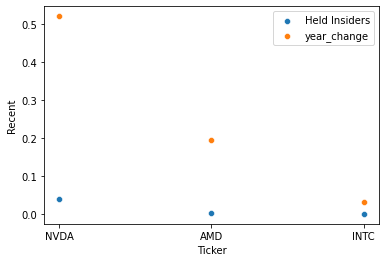

In [33]:
heldInsiders = combined_data[combined_data['Attributes'] == 'heldPercentInsiders']
year_change = combined_data[combined_data['Attributes'] == '52WeekChange']

display(heldInsiders, year_change)

sns.scatterplot(x=heldInsiders['Ticker'], y=heldInsiders['Recent'], label='Held Insiders')
sns.scatterplot(x=year_change['Ticker'], y=year_change['Recent'], label='year_change')

In [14]:
os.getcwd()

'c:\\Users\\huyho\\OneDrive\\Desktop\\stuff\\p-projects\\stock-forecasting'

In [15]:
latitude = [37.3860884556, 37.3691018569, 37.38242485333451]
longitude = [-121.958119501, -121.9582395, -121.97017259436115]
comp_ticker = ['INTC', 'NVDA', 'AMD']
color = ['blue', 'green', 'red'] 

t = zip(latitude, longitude, comp_ticker, color)
result_t = set(t)
result_t

{(37.3691018569, -121.9582395, 'NVDA', 'green'),
 (37.38242485333451, -121.97017259436115, 'AMD', 'red'),
 (37.3860884556, -121.958119501, 'INTC', 'blue')}

In [16]:
#given that they are all headquartered in Santa Clara, let's visualize the proximity of these companies

m = folium.Map([37.3541, -121.9552], zoom_start=12)

for lat, lon, ticker, color in result_t:
    folium.Marker([lat, lon], popup=ticker, icon=folium.Icon(color=color)).add_to(m)
m

In [27]:
nvda_table = data['NVDA']
nvda_table['Month'] = nvda_table['Open'].index.month
nvda_month_grouped = nvda_table.groupby('Month').mean()

amd_table = data['AMD']
amd_table['Month'] = amd_table['Open'].index.month
amd_month_grouped = amd_table.groupby('Month').mean()

intc_table = data['INTC']
intc_table['Month'] = intc_table['Open'].index.month
intc_month_grouped = intc_table.groupby('Month').mean()

intc_month_grouped

<ipython-input-27-64b9c9e17de8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda_table['Month'] = nvda_table['Open'].index.month
<ipython-input-27-64b9c9e17de8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amd_table['Month'] = amd_table['Open'].index.month
<ipython-input-27-64b9c9e17de8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

,Open,High,Low,Close,Adj Close,Volume
Month,,,,,,
1,42.463148,43.017901,41.996975,42.496667,38.698484,3.470906e+07
2,43.011765,43.510654,42.551307,43.058889,39.546914,2.577163e+07
3,42.904057,43.660000,42.314514,42.972000,39.504302,3.082112e+07
4,44.498976,45.017289,43.961506,44.499157,40.906888,2.816236e+07
5,42.757798,43.185774,42.358095,42.792678,39.456259,2.311837e+07
6,43.275581,43.639070,42.816337,43.219477,39.888254,2.665397e+07
7,43.044706,43.443294,42.615588,43.063529,39.683551,2.866230e+07
8,39.818397,40.153782,39.471667,39.815833,36.322563,2.524401e+07
9,40.490210,40.894825,40.134895,40.551608,36.941025,2.592782e+07


<AxesSubplot:xlabel='Month', ylabel='Volume'>

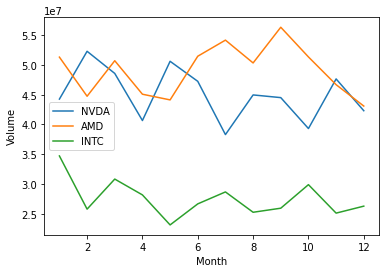

In [29]:
sns.lineplot(x=nvda_month_grouped['Volume'].index, y=nvda_month_grouped['Volume'], label='NVDA')
sns.lineplot(x=amd_month_grouped['Volume'].index, y=amd_month_grouped['Volume'], label='AMD')
sns.lineplot(x=intc_month_grouped['Volume'].index, y=intc_month_grouped['Volume'], label='INTC')
#volume seems to decrease significantly during the summer months

# ARIMA

<p1> ARIMA models expect p, d, q as input parameters <p1>
1. p is the number of lag observations.
2. d is the degree of differencing.
3. q is the size/width of the moving average window. 


In [16]:
nvda = pd.DataFrame(data['NVDA']['Close'])
nvda.columns = ['Close']
nvda

,Close
Date,
2014-01-02,3.965000
2014-01-03,3.917500
2014-01-06,3.970000
2014-01-07,4.035000
2014-01-08,4.090000
...,...
2021-07-28,195.029999
2021-07-29,196.619995
2021-07-30,194.990005


In [17]:
#Before we can do ARIMA, we should look at the autocorrelation

from pandas.plotting import lag_plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 5)'>

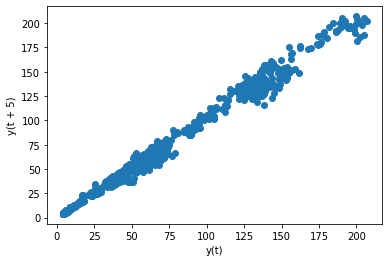

In [18]:
lag_plot(nvda['Close'], lag=5)

In [19]:
train_nvda, test_nvda = nvda[0:int(len(nvda) * 0.8)], nvda[int(len(nvda) * 0.8):]
print('training set shape', train_nvda.shape)
print('testing set shape', test_nvda.shape)

training set shape (1528, 1)
testing set shape (382, 1)


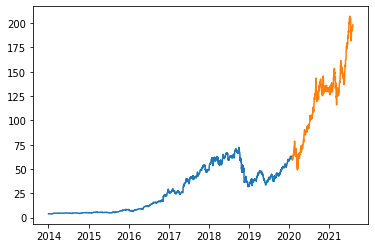

In [20]:
plt.plot(train_nvda)
plt.plot(test_nvda)

In [21]:
train_nvda, test_nvda = train_nvda.values, test_nvda.values

In [22]:
history = [x for x in train_nvda]
model_predictions = []
N_test_observations = len(test_nvda) #382

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_nvda[time_point]
    history.append(true_test_value)

mse_error = mean_squared_error(test_nvda, model_predictions)
print('Testing MSE is', mse_error)

C:\Users\huyho\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Testing MSE is 12.550908427899701


In [23]:
from matplotlib.pyplot import figure

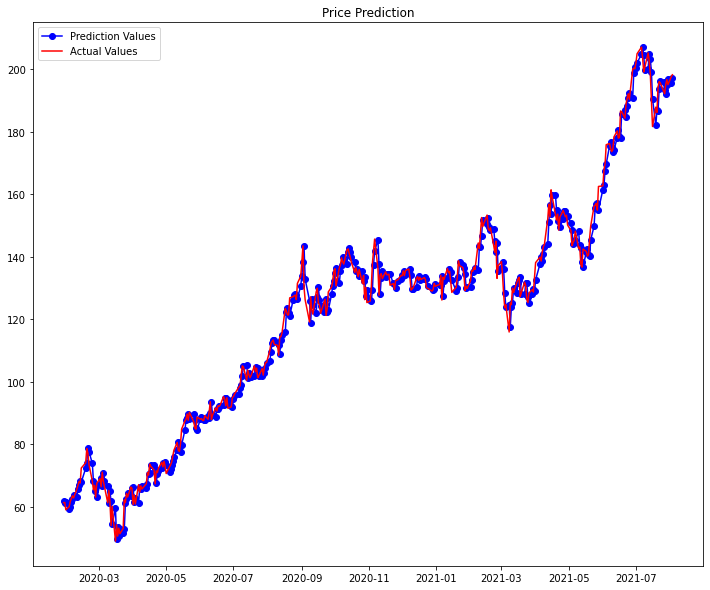

In [24]:
test_set_range = nvda[int(len(nvda) * 0.8):].index

plt.figure(figsize=(12,10))
plt.plot(test_set_range, model_predictions, color='blue', label='Prediction Values', marker='o')
plt.plot(test_set_range, test_nvda, color='red', label='Actual Values')

plt.title('Price Prediction')
plt.legend()
plt.show()

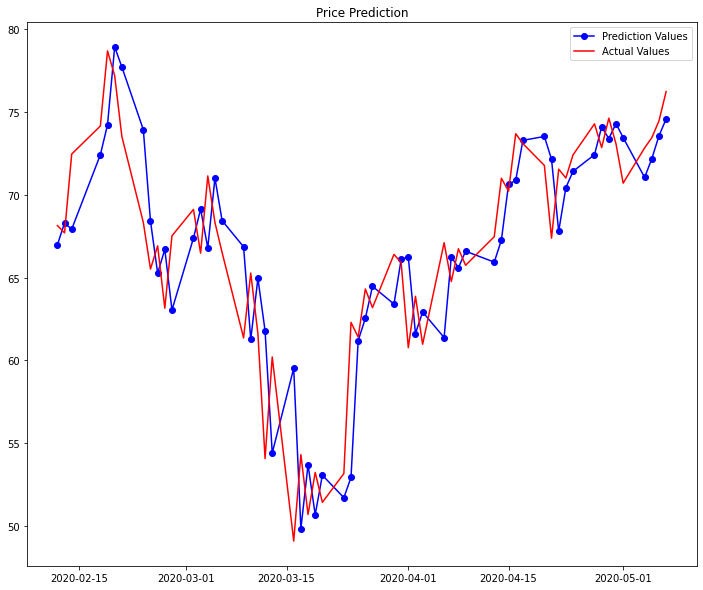

In [25]:
#looking at a smaller subset
plt.figure(figsize=(12,10))
plt.plot(test_set_range[10:70], model_predictions[10:70], color='blue', label='Prediction Values', marker='o')
plt.plot(test_set_range[10:70], test_nvda[10:70], color='red', label='Actual Values')

plt.title('Price Prediction')
plt.legend()
plt.show()

## ARIMA seems to do a pretty decent job. Of course there are instances where it might not be as reliable, for example during the market crash during the Covid-19 pandemic. However, it looks like a reliable model that is relatively simple to build.

# We'll try XGBOOST

In [26]:
xgboost_nvda = data['NVDA']

In [27]:
xgboost_nvda['target'] = xgboost_nvda['Close'].copy()
xgboost_nvda['target'] = xgboost_nvda['Close'].shift(-1)
xgboost_nvda.dropna(inplace=True)
xgboost_nvda

<ipython-input-27-216cefc43c65>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgboost_nvda['target'] = xgboost_nvda['Close'].copy()
<ipython-input-27-216cefc43c65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgboost_nvda['target'] = xgboost_nvda['Close'].shift(-1)
<ipython-input-27-216cefc43c65>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,Open,High,Low,Close,Adj Close,Volume,target
Date,,,,,,,
2014-01-02,3.980000,3.995000,3.930000,3.965000,3.747001,26009200,3.917500
2014-01-03,3.972500,3.980000,3.905000,3.917500,3.702113,25933200,3.970000
2014-01-06,3.957500,4.000000,3.920000,3.970000,3.751726,40949200,4.035000
2014-01-07,4.010000,4.050000,3.982500,4.035000,3.813152,33328800,4.090000
2014-01-08,4.050000,4.110000,4.035000,4.090000,3.865128,30819200,3.937500
...,...,...,...,...,...,...,...
2021-07-27,192.649994,196.220001,187.410004,192.080002,192.080002,24886300,195.029999
2021-07-28,193.190002,196.460007,189.949997,195.029999,195.029999,20219100,196.619995
2021-07-29,195.190002,198.529999,193.279999,196.619995,196.619995,19078100,194.990005


In [28]:
xgboost_nvda['target'][0] == xgboost_nvda['Close'][1]
#the target is the next date's closing price

True

In [29]:
xgboost_nvda_train, xgboost_nvda_test = xgboost_nvda[0:int(len(xgboost_nvda) * 0.8)], xgboost_nvda[int(len(xgboost_nvda) * 0.8):]
print('train length: ', len(xgboost_nvda_train))
print('test length: ', len(xgboost_nvda_test))

train length:  1527
test length:  382


In [30]:
train_X= xgboost_nvda_train.iloc[:, :-1]
train_Y= xgboost_nvda_train.iloc[:, -1]
test_X = xgboost_nvda_test.iloc[:, :-1]
test_Y = xgboost_nvda_test.iloc[:, -1]

In [31]:
modelXGB = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
modelXGB.fit(train_X, train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# keraS

In [80]:
nvda_train = nvda[:int(len(nvda) * 0.7)]
nvda_test = nvda[int(len(nvda) * 0.7):]
print('nvda train:' , len(nvda_train))
print('nvda test:' , len(nvda_test))

nvda train: 1337
nvda test: 573


In [81]:
display(nvda_train, nvda_test)

,Close
Date,
2014-01-02,3.965000
2014-01-03,3.917500
2014-01-06,3.970000
2014-01-07,4.035000
2014-01-08,4.090000
...,...
2019-04-18,46.575001
2019-04-22,47.117500
2019-04-23,47.667500


,Close
Date,
2019-04-26,44.522499
2019-04-29,44.832500
2019-04-30,45.250000
2019-05-01,45.117500
2019-05-02,45.797501
...,...
2021-07-28,195.029999
2021-07-29,196.619995
2021-07-30,194.990005


In [82]:
scaler = MinMaxScaler()
scaler.fit(nvda_train)

MinMaxScaler()

In [83]:
scaled_train = scaler.transform(nvda_train)
scaled_test = scaler.transform(nvda_test)

In [84]:
n_input = 300 #window size of 300
n_feature = 1 #univariate


#creating the generator for training and testing
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=1)

In [85]:
#MODEL

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(n_input, n_feature))) #(200, 1)
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(filters=1024, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(filters=2048, kernel_size=3, activation='relu', padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=n_feature)) #1
model.compile(optimizer='adam', loss='mse')

#stochastic gradient descent sgd, mse is best for outlier detection

In [86]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 300, 64)           256       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 150, 64)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 150, 128)          24704     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 75, 128)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 75, 256)           98560     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 37, 256)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 37, 512)          

In [87]:
model.fit(train_generator, epochs=10, batch_size=50, verbose=2)

Epoch 1/10
1037/1037 - 63s - loss: 0.0383
Epoch 2/10
1037/1037 - 58s - loss: 0.0044
Epoch 3/10
1037/1037 - 60s - loss: 0.0026
Epoch 4/10
1037/1037 - 60s - loss: 0.0017
Epoch 5/10
1037/1037 - 58s - loss: 0.0024
Epoch 6/10
1037/1037 - 59s - loss: 0.0012
Epoch 7/10
1037/1037 - 57s - loss: 0.0018
Epoch 8/10
1037/1037 - 57s - loss: 0.0041
Epoch 9/10
1037/1037 - 57s - loss: 0.0015
Epoch 10/10
1037/1037 - 57s - loss: 0.0016


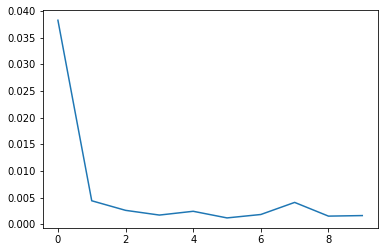

In [88]:
model_loss= model.history.history['loss']
plt.plot(range(len(model_loss)), model_loss)

In [89]:
test_predictions = []
train_predictions = []

#how far into the future will I forecast?
#loop through test window
for x,_ in test_generator:
    
    # One timestep ahead of historical 300 points
    current_pred = model.predict(x)
    
    #store that prediction
    test_predictions.append(current_pred[0])


for x,_ in train_generator:
    
    # One timestep ahead of historical 300 points
    current_pred_train = model.predict(x)
    
    #store that prediction
    train_predictions.append(current_pred_train[0])


#reverse the scaled into normal total_mbps
train_predictions = scaler.inverse_transform(train_predictions)
true_predictions = scaler.inverse_transform(test_predictions)

In [90]:
test_result = nvda_test[300:]
test_result['predictions'] = true_predictions
test_result

<ipython-input-90-c0c33025bcf8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = true_predictions


,Close,predictions
Date,,
2020-07-06,98.392502,94.873196
2020-07-07,98.717499,96.338041
2020-07-08,102.160004,97.708962
2020-07-09,105.089996,99.591620
2020-07-10,104.792503,102.716212
...,...,...
2021-07-28,195.029999,189.021658
2021-07-29,196.619995,187.811171
2021-07-30,194.990005,189.409617


In [91]:
import seaborn as sns 

<AxesSubplot:xlabel='Date', ylabel='Close'>

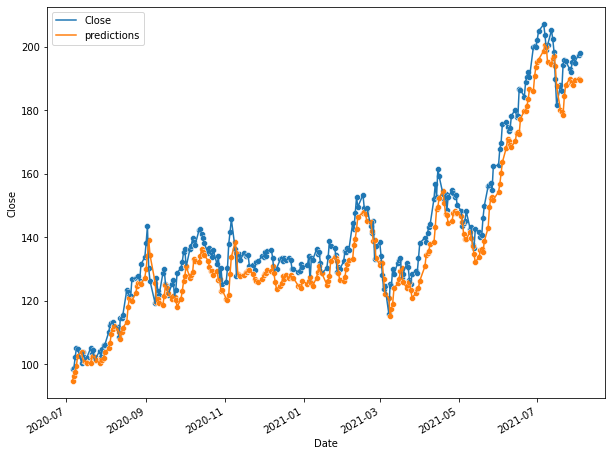

In [92]:
test_result[['Close', 'predictions']].plot(figsize=(10,8))
sns.scatterplot(x=test_result.index, y=test_result.Close)
sns.scatterplot(x=test_result.index, y=test_result.predictions)

In [93]:
#train results
train_result = nvda_train[300:]
train_result['predictions'] = train_predictions
train_result

<ipython-input-93-2ef0003d4ef9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_result['predictions'] = train_predictions


,Close,predictions
Date,,
2015-03-13,5.675000,6.005293
2015-03-16,5.742500,6.005099
2015-03-17,5.812500,6.006571
2015-03-18,5.717500,6.009799
2015-03-19,5.805000,6.010696
...,...,...
2019-04-18,46.575001,47.605634
2019-04-22,47.117500,47.670369
2019-04-23,47.667500,47.793228


<AxesSubplot:xlabel='Date'>

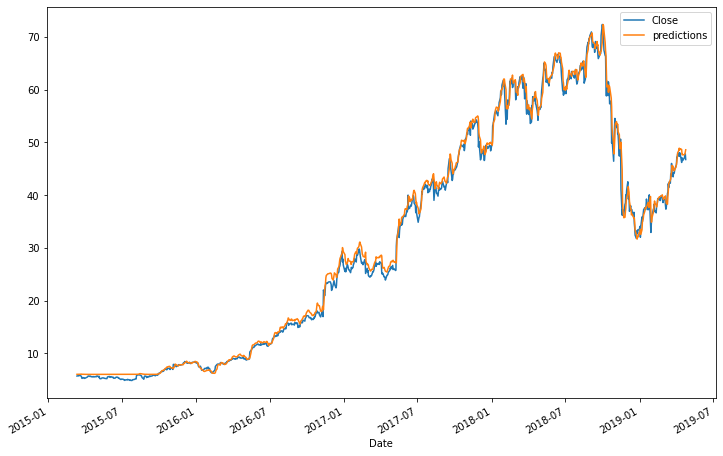

In [94]:
train_result.plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

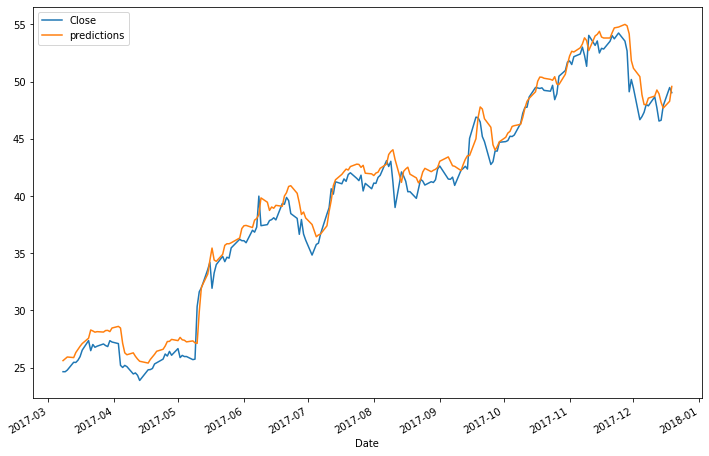

In [95]:
train_result[500:700].plot(figsize=(12,8))